In [1]:
### Load and Preprocess - 50k/10k/10k train/val/test ###

from collections import Counter
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


(X_train_val_unscaled, y_train_val), (X_test_unscaled, y_test) = tf.keras.datasets.mnist.load_data()

# Scale pixel values to b/w 0 and 1
X_train_val = (X_train_val_unscaled / 255).astype(np.float32)
X_test = (X_test_unscaled / 255).astype(np.float32)

# Shuffle + stratified split the 60k X_train_val into 50k/10k X_train/X_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Print info on the preprocessed data
print(f'Train: num_samples={len(X_train)} | priors={dict(sorted(Counter(y_train).items()))}')
print(f'Val: num_samples={len(X_val)} | priors={dict(sorted(Counter(y_val).items()))}')
print(f'Test: num_samples={len(X_test)} | priors={dict(sorted(Counter(y_test).items()))}')

Train: num_samples=48000 | priors={0: 4738, 1: 5394, 2: 4766, 3: 4905, 4: 4674, 5: 4337, 6: 4734, 7: 5012, 8: 4681, 9: 4759}
Val: num_samples=12000 | priors={0: 1185, 1: 1348, 2: 1192, 3: 1226, 4: 1168, 5: 1084, 6: 1184, 7: 1253, 8: 1170, 9: 1190}
Test: num_samples=10000 | priors={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [2]:
### Create and run hyperband tuner ###

def build_model(hp):
    """Model building function."""

    # Define hyperparameters to tune
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, default=2)
    hidden_layer_size = hp.Choice('hidden_layer_size', values=[32, 64, 128, 256], default=128)
    activation = hp.Choice('activation', values=['relu', 'tanh'], default='relu')
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, default=0.2, step=0.05)
    l2_strength = hp.Choice('l2_strength', values=[0.0001, 0.001, 0.01], default=0.001)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, default=0.001, step=0.001)

    # Build the model
    input_size = (28, 28)
    output_size = 10

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_size))
    model.add(tf.keras.layers.Flatten())
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
            )
        )
        # Dropout layer after each Dense layer
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


MAX_EPOCHS = 150
batch_size = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=MAX_EPOCHS,
    factor=3,
    directory='tuning_results',
    project_name=f'dense_batch{batch_size}'
)

tuner.search(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2
)

Trial 254 Complete [00h 00m 16s]
val_loss: 0.3119581937789917

Best val_loss So Far: 0.08756891638040543
Total elapsed time: 00h 42m 12s


In [3]:
### Get the best model, hyperparameters, and metrics ###

# Best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Metrics
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_metrics = best_trial.metrics
train_loss = best_metrics.get_history('loss')[-1].value[0]
train_accuracy = best_metrics.get_history('accuracy')[-1].value[0]
val_loss = best_metrics.get_history('val_loss')[-1].value[0]
val_accuracy = best_metrics.get_history('val_accuracy')[-1].value[0]
last_epoch = best_metrics.get_history('loss')[-1].step

# Display best hp and metrics
print(f'Trained for {last_epoch} epochs')
print(f'Accuracy: Train={train_accuracy * 100:.2f}% | Val={val_accuracy * 100:.2f}%')
print(f'Loss: Train={train_loss:.4f} | Val={val_loss:.4f}')

Best Hyperparameters:  {'num_hidden_layers': 1, 'hidden_layer_size': 256, 'activation': 'relu', 'dropout_rate': 0.4, 'l2_strength': 0.0001, 'learning_rate': 0.0001, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}
Trained for 49 epochs
Accuracy: Train=99.19% | Val=98.13%
Loss: Train=0.0524 | Val=0.0876


In [ ]:
### Exploring trial results ###

num_to_explore = 10
best_models = tuner.get_best_models(num_models=num_to_explore)
best_trials = tuner.oracle.get_best_trials(num_trials=num_to_explore)
best_hps = tuner.get_best_hyperparameters(num_trials=num_to_explore)
for i in range(num_to_explore):
    trial_i = best_trials[i]
    hp_i = best_hps[i]
    loss_i = trial_i.metrics.get_history('loss')[-1].value[0]
    val_loss_i = trial_i.metrics.get_history('val_loss')[-1].value[0]
    print('-------------------------')
    print(f'#{i + 1} Best Trial Results')
    print(f'Training Loss: {loss_i:.4f}')
    print(f'Validation Loss: {val_loss_i:.4f}')
    print(f'Train - Val Loss: {loss_i - val_loss_i:.4f}')
    print(f'Hyperparameters: {hp_i.values}')

-------------------------
#1 Best Trial Results
Training Loss: 0.0524
Validation Loss: 0.0876
Train - Val Loss: -0.0352
Hyperparameters: {'num_hidden_layers': 1, 'hidden_layer_size': 256, 'activation': 'relu', 'dropout_rate': 0.4, 'l2_strength': 0.0001, 'learning_rate': 0.0001, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}
-------------------------
#2 Best Trial Results
Training Loss: 0.0811
Validation Loss: 0.1014
Train - Val Loss: -0.0203
Hyperparameters: {'num_hidden_layers': 1, 'hidden_layer_size': 256, 'activation': 'relu', 'dropout_rate': 0.4, 'l2_strength': 0.0001, 'learning_rate': 0.0001, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 4, 'tuner/round': 3, 'tuner/trial_id': '0138'}
-------------------------
#3 Best Trial Results
Training Loss: 0.1521
Validation Loss: 0.1370
Train - Val Loss: 0.0152
Hyperparameters: {'num_hidden_layers': 2, 'hidden_layer_size': 64, 'activation': 'tanh', 'dropout_ra

In [6]:
### Re-training model 1 with higher MAX_EPOCHS, higher patience, and smaller batch size ###

MAX_EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 10

input_size = (28, 28)
output_size = 10

# Hyperparameters
num_hidden_layers = 1
hidden_layer_size = 256
activation='relu'
learning_rate = 0.0001
l2_strength = 0.0001
dropout_rate = 0.4

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))
model.add(tf.keras.layers.Flatten())
for _ in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            hidden_layer_size,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
        )
    )
    # Dropout layer after each Dense layer
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500
1500/1500 - 4s - 2ms/step - accuracy: 0.8061 - loss: 0.7352 - val_accuracy: 0.9094 - val_loss: 0.3705
Epoch 2/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9041 - loss: 0.3717 - val_accuracy: 0.9276 - val_loss: 0.2962
Epoch 3/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9191 - loss: 0.3110 - val_accuracy: 0.9376 - val_loss: 0.2567
Epoch 4/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9306 - loss: 0.2719 - val_accuracy: 0.9427 - val_loss: 0.2319
Epoch 5/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9399 - loss: 0.2418 - val_accuracy: 0.9487 - val_loss: 0.2125
Epoch 6/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9439 - loss: 0.2239 - val_accuracy: 0.9525 - val_loss: 0.1962
Epoch 7/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9496 - loss: 0.2071 - val_accuracy: 0.9565 - val_loss: 0.1834
Epoch 8/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9530 - loss: 0.1931 - val_accuracy: 0.9588 - val_loss: 0.1744
Epoch 9/500
1500/1500 - 3s - 2ms/step - accuracy: 0.9569 - loss: 0.1798 - val_accuracy: 

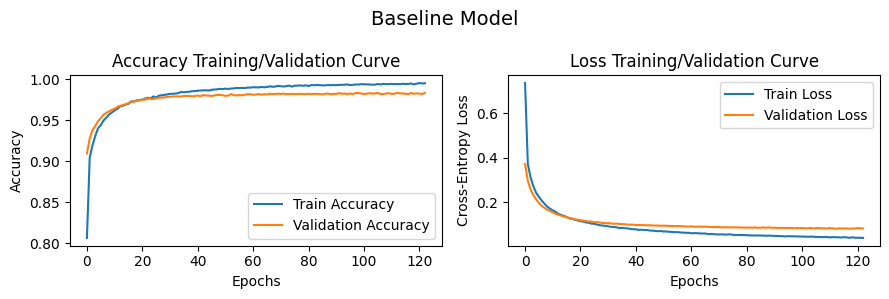

Final Results after 123 epochs:
Accuracy: Train=99.50% | Val=98.32%
Loss: Train=0.0389 | Val=0.0812


In [ ]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].legend()

# Show plots
fig.suptitle('Hyperband-Tuned Model', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Final Results after {len(history.history['accuracy'])} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][-1] * 100:.2f}% | Val={history.history['val_accuracy'][-1] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][-1]:.4f} | Val={history.history['val_loss'][-1]:.4f}')

In [14]:
### Clean up tuning_results folder by purging all but top 10 models (but retain metrics results and hps) ###

import os

# Get ids for top trials
top_trials = tuner.oracle.get_best_trials(num_trials=10)
top_trial_ids = {trial.trial_id for trial in top_trials}

# Loop through all trial subfolders
results_dir = 'tuning_results/dense_batch64'
for trial_folder in os.listdir(results_dir):
    trial_path = os.path.join(results_dir, trial_folder)
    
    # Delete model checkpoint, but retain metrics and hps
    if os.path.isdir(trial_path) and trial_folder not in top_trial_ids:
        for file in os.listdir(trial_path):
            if 'checkpoint' in file or file.endswith('.h5'):
                os.remove(os.path.join(trial_path, file))